In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=b43c7d0e7f3337bbcc7af39fee34966a9df73379bafaa847cd7446a48d907681
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [28]:
hdfs_path = "hdfs://user/hadoop/data.csv"

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("YourApp").config("spark.sql.legacy.timeParserPolicy", "LEGACY").getOrCreate()




In [ ]:
df0 = spark.read.csv("drive/MyDrive/TwitterData/bigboy.csv", header=True, inferSchema=True)
df1 = spark.read.csv("drive/MyDrive/TwitterData/datum1.csv", header=True, inferSchema=True)
df2 = spark.read.csv("drive/MyDrive/TwitterData/datum2.csv", header=True, inferSchema=True)
df3 = spark.read.csv("drive/MyDrive/TwitterData/datum3.csv", header=True, inferSchema=True)

In [ ]:
from functools import reduce
from pyspark.sql import DataFrame

df0 = df0.drop("number")
dfs = [df0,df1, df2, df3]

df = reduce(DataFrame.union, dfs)



In [4]:
df = spark.read.csv("small_data.csv", header=True, inferSchema=True)

In [5]:
df.printSchema()
print("Columns: ", df.columns)
print("Rows: ", df.count())

root
 |-- id: string (nullable = true)
 |-- url: string (nullable = true)
 |-- full_text: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- reply_count: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- likes: string (nullable = true)
 |-- publicationtime: string (nullable = true)
 |-- creator_followers_count: integer (nullable = true)

Columns:  ['id', 'url', 'full_text', 'hashtags', 'reply_count', 'lang', 'user_name', 'likes', 'publicationtime', 'creator_followers_count']
Rows:  201


In [6]:

df = df.dropDuplicates()

df = df.na.drop(subset=["full_text", "publicationtime"])




In [19]:
df = df.drop("id", "url", "lang", "user_name" , "creator_followers_count")

In [8]:
from pyspark.sql.functions import col, to_timestamp, hour, minute, second, concat_ws


df = df.withColumn('publicationtime', to_timestamp(col('publicationtime'), 'EEE MMM dd HH:mm:ss Z yyyy'))

df = df.withColumn('date', df['publicationtime'].cast('date'))
df = df.withColumn('time', concat_ws(':', hour(df['publicationtime']), minute(df['publicationtime']), second(df['publicationtime'])))



In [9]:
df.show()

+--------------------+--------------------+-----------+----+---------------+-----+-------------------+----------+--------+
|           full_text|            hashtags|reply_count|lang|      user_name|likes|    publicationtime|      date|    time|
+--------------------+--------------------+-----------+----+---------------+-----+-------------------+----------+--------+
|#Kholi #DLM #Liqo...|Kholi,DLM,Liqouro...|          0|  en|        TiitweN|   14|2021-12-09 17:50:25|2021-12-09|17:50:25|
|The crew @spiderm...|SpiderManNoWayHom...|          0|  en|      erathrim_|    4|2021-12-09 17:54:41|2021-12-09|17:54:41|
|#RT @houstonisdwa...|             RT,HISD|          0|  en|  HISD_Outreach|    1|2021-12-09 17:50:25|2021-12-09|17:50:25|
|@classicallygia H...|Survivor41,Surviv...|          0|  en|        seb1959|    1|2021-12-09 17:50:22|2021-12-09|17:50:22|
|Signing day nears...|Rutgers,RFootball...|          2|  en|  TodderickHunt|   32|2021-12-09 17:50:25|2021-12-09|17:50:25|
|#HIDAYAT_THE_RA

In [10]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [11]:
from pyspark.sql.functions import *
from pyspark.sql.types import StringType, BooleanType
import re

def remove_emojis(text):
    return text.encode('ascii', 'ignore').decode('ascii')

remove_emojis_udf = udf(remove_emojis, StringType())

def remove_special_characters(text):
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return cleaned_text

remove_special_characters_udf = udf(remove_special_characters, StringType())

def remove_urls(text):
    cleaned_text = re.sub(r'http\S+', '', text)
    return cleaned_text

remove_urls_udf = udf(remove_urls, StringType())

df = df.withColumn("full_text", remove_emojis_udf("full_text"))
df = df.withColumn("full_text", remove_special_characters_udf(df["full_text"]))
df = df.withColumn("full_text", remove_urls_udf(df["full_text"]))

df = df.withColumn("hashtags", remove_emojis_udf("hashtags"))
df = df.withColumn("hashtags", remove_special_characters_udf(df["hashtags"]))
df = df.withColumn("hashtags", remove_urls_udf(df["hashtags"]))


def is_english(text):
    try:
        text.encode(encoding='utf-8').decode('ascii')
        return True
    except UnicodeDecodeError:
        return False

is_english_udf = udf(is_english, BooleanType())
df = df.filter(is_english_udf(df['full_text']))

tokenizer = Tokenizer(inputCol="full_text", outputCol="raw_tokens")
df = tokenizer.transform(df)

remover = StopWordsRemover(inputCol="raw_tokens", outputCol="tokens")
df = remover.transform(df)

df = df.drop("raw_tokens")

#df.show()


In [12]:
df = df.drop("publicationtime")

In [20]:
sid = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    sentiment_score = sid.polarity_scores(text)
    if sentiment_score['compound'] > 0.05:
        return 2
    elif sentiment_score['compound'] < -0.05:
        return 0
    else:
        return 1

sentiment_udf = udf(analyze_sentiment, IntegerType())

df = df.withColumn('sentiment_score', sentiment_udf(df['full_text']))

df.show()


+--------------------+--------------------+-----------+-----+----------+--------+--------------------+---------+---------------+
|           full_text|            hashtags|reply_count|likes|      date|    time|              tokens|sentiment|sentiment_score|
+--------------------+--------------------+-----------+-----+----------+--------+--------------------+---------+---------------+
|Kholi DLM Liqouro...|KholiDLMLiqourose...|          0|   14|2021-12-09|17:50:25|[kholi, dlm, liqo...|        1|              1|
|The crew spiderma...|SpiderManNoWayHom...|          0|    4|2021-12-09|17:54:41|[crew, spidermanm...|        1|              1|
|RT houstonisdwatc...|              RTHISD|          0|    1|2021-12-09|17:50:25|[rt, houstonisdwa...|        2|              2|
|classicallygia Ha...|Survivor41Survivo...|          0|    1|2021-12-09|17:50:22|[classicallygia, ...|        0|              0|
|Signing day nears...|RutgersRFootballB...|          2|   32|2021-12-09|17:50:25|[signing, day, n

In [23]:
from pyspark.sql import functions as F

df = df.withColumn(
    "sentiment",
    F.when(F.col("sentiment_score") == 2, "positive")
    .when(F.col("sentiment_score") == 0, "negative")
    .when(F.col("sentiment_score") == 1, "neutral")
    .otherwise(None)
)

<h2>Part 2</h2>

In [25]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, IDF

hashingTF = HashingTF(inputCol="tokens", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.01, labelCol="sentiment_score", featuresCol="features")

pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, lr])

train_data = df.sample(fraction=0.8, seed=42)
test_data = df.subtract(train_data)

model = pipeline.fit(train_data)


predictions = model.transform(test_data)

predictions = predictions.drop("lang","raw_tokens", "rawFeatures", "features", "rawPrediction", "probability")
predictions.show()


+--------------------+--------------------+-----------+--------------------+----------+--------+--------------------+---------------+---------+----------+
|           full_text|            hashtags|reply_count|               likes|      date|    time|              tokens|sentiment_score|sentiment|prediction|
+--------------------+--------------------+-----------+--------------------+----------+--------+--------------------+---------------+---------+----------+
|I cant wait to se...|SpecialTeamsMulti...|          0|                   1|2021-12-09|17:50:24|[cant, wait, see,...|              1|  neutral|       1.0|
|BethRigby SamCoat...|       ElectionsBill|          0|                   0|2021-12-09|17:54:41|[bethrigby, samco...|              2| positive|       1.0|
|Around 25 of LGBT...|youarenotalone16d...|          0|                   1|2021-12-09|17:50:23|[around, 25, lgbt...|              1|  neutral|       1.0|
|Whats up with the...|     AndJustLikeThat|          1|               

In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction")

# Accuracy
accuracy = evaluator.evaluate(full_predictions, {evaluator.metricName: "accuracy"})
print("Accuracy:", accuracy)

# Precision
precision = evaluator.evaluate(full_predictions, {evaluator.metricName: "weightedPrecision"})
print("Precision:", precision)

# Recall
recall = evaluator.evaluate(full_predictions, {evaluator.metricName: "weightedRecall"})
print("Recall:", recall)

# F1-score
f1_score = evaluator.evaluate(full_predictions, {evaluator.metricName: "f1"})
print("F1-score:", f1_score)

Accuracy: 0.8846153846153846
Precision: 0.8913863913863913
Recall: 0.8846153846153846
F1-score: 0.8849385908209437


In [26]:
full_predictions = model.transform(df)

full_predictions = full_predictions.drop("lang","raw_tokens", "rawFeatures", "features", "rawPrediction", "probability")
full_predictions.show()

+--------------------+--------------------+-----------+-----+----------+--------+--------------------+---------------+---------+----------+
|           full_text|            hashtags|reply_count|likes|      date|    time|              tokens|sentiment_score|sentiment|prediction|
+--------------------+--------------------+-----------+-----+----------+--------+--------------------+---------------+---------+----------+
|Kholi DLM Liqouro...|KholiDLMLiqourose...|          0|   14|2021-12-09|17:50:25|[kholi, dlm, liqo...|              1|  neutral|       1.0|
|The crew spiderma...|SpiderManNoWayHom...|          0|    4|2021-12-09|17:54:41|[crew, spidermanm...|              1|  neutral|       1.0|
|RT houstonisdwatc...|              RTHISD|          0|    1|2021-12-09|17:50:25|[rt, houstonisdwa...|              2| positive|       0.0|
|classicallygia Ha...|Survivor41Survivo...|          0|    1|2021-12-09|17:50:22|[classicallygia, ...|              0| negative|       0.0|
|Signing day nears..

In [27]:
df.createOrReplaceTempView("sentiments_table")

sentiment_distribution = spark.sql("""
    SELECT sentiment, COUNT(*) AS count
    FROM sentiments_table
    GROUP BY sentiment
    ORDER BY count DESC
""")

sentiment_distribution.show()

+---------+-----+
|sentiment|count|
+---------+-----+
| positive|   24|
|  neutral|   20|
| negative|    8|
+---------+-----+



In [ ]:
from pyspark.sql.functions import explode, col

df_words = df.select(explode("tokens").alias("word"))

top_keywords = df_words.groupBy("word").count().orderBy(col("count").desc())

top_keywords.show()

+---------------+-----+
|           word|count|
+---------------+-----+
|               |   15|
|             go|    6|
|           like|    5|
|        started|    4|
|andjustlikethat|    3|
|       everyday|    3|
|           2020|    3|
|           cant|    3|
|            one|    3|
|           food|    3|
|           boys|    3|
|        support|    3|
|            see|    3|
|  patmcafeeshow|    3|
|           well|    3|
|           crew|    3|
|           fans|    3|
|           keep|    3|
|   axionnetwork|    2|
|            day|    2|
+---------------+-----+
only showing top 20 rows



In [ ]:

engagement_metrics = df.selectExpr(
    "SUM(likes) AS total_likes",
    "AVG(likes) AS avg_likes_per_post",
    "SUM(reply_count) AS total_comments",
)

engagement_metrics.show()


+-----------+------------------+--------------+
|total_likes|avg_likes_per_post|total_comments|
+-----------+------------------+--------------+
|      289.0| 5.666666666666667|          30.0|
+-----------+------------------+--------------+



<h2>Visualization</h2>

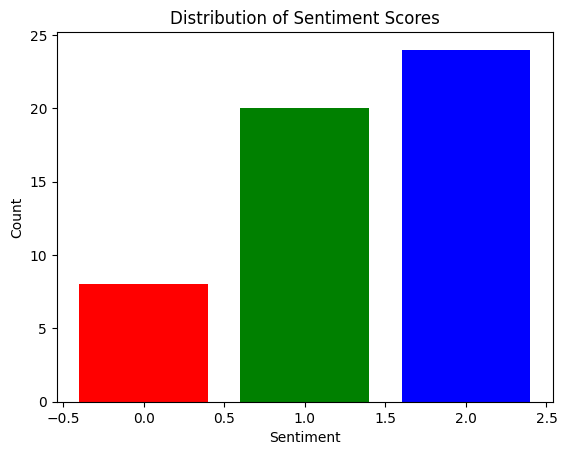

In [ ]:
import matplotlib.pyplot as plt

colors = ['red', 'green', 'blue']

sentiment_counts = df.groupBy('sentiment').count().orderBy('sentiment').toPandas()
plt.bar(sentiment_counts['sentiment'], sentiment_counts['count'], color=colors)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


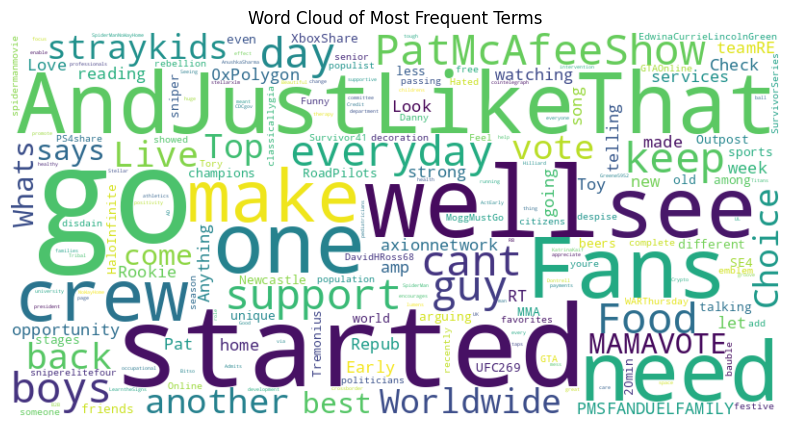

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_df = df.select('full_text')

text_rdd = text_df.rdd.map(lambda x: x[0])

text = ' '.join(text_rdd.collect())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Most Frequent Terms')
plt.axis('off')
plt.show()


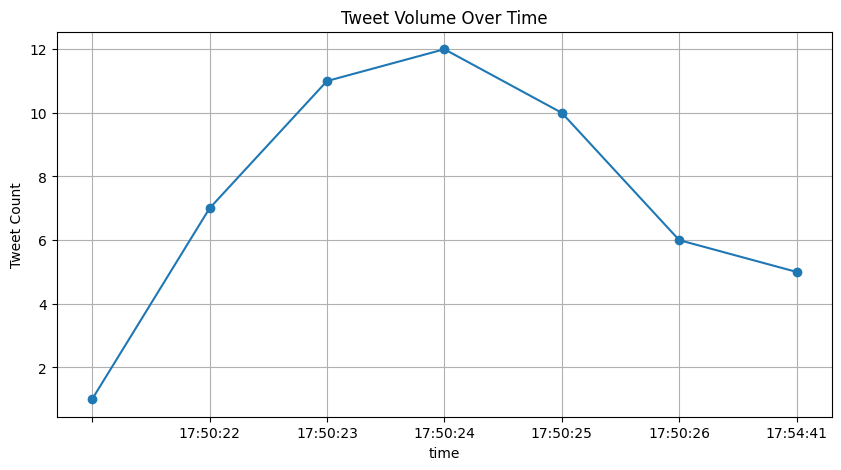

In [ ]:
tweet_counts = df.groupBy('time').count().orderBy('time').toPandas()

plt.figure(figsize=(10, 5))
plt.plot(tweet_counts['time'], tweet_counts['count'], marker='o', linestyle='-')
plt.title('Tweet Volume Over Time')
plt.xlabel('time')
plt.ylabel('Tweet Count')
plt.grid(True)
plt.show()



In [ ]:
def filter_long_hashtags(hashtags):
    filtered_hashtags = [hashtag for hashtag in hashtags.split(',') if len(hashtag) <= 30]
    return ','.join(filtered_hashtags)


filter_long_hashtags_udf = udf(filter_long_hashtags, StringType())

df = df.withColumn("hashtags", filter_long_hashtags_udf("hashtags"))

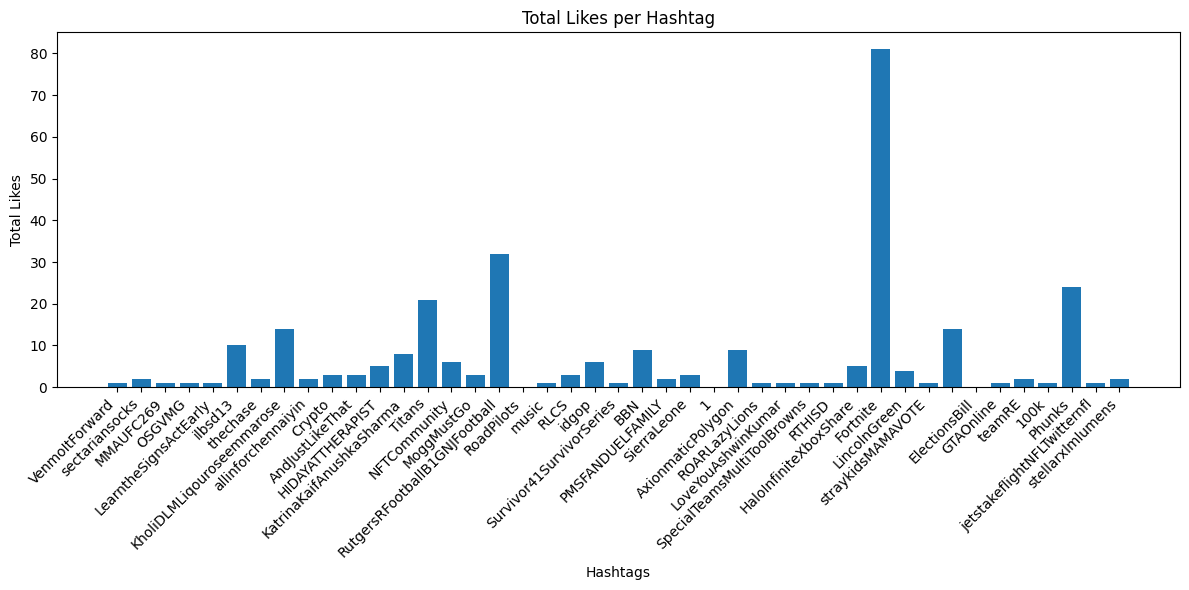

In [ ]:
likes_per_hashtag = df.groupBy('hashtags').sum('likes').toPandas()



# Plot the chart
plt.figure(figsize=(12, 6))
plt.bar(likes_per_hashtag['hashtags'], likes_per_hashtag['sum(likes)'])
plt.xlabel('Hashtags')
plt.ylabel('Total Likes')
plt.title('Total Likes per Hashtag')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px

fig = px.line(tweet_counts, x='time', y='count', title='Tweet Volume Over Time')

fig.show()